##  - Cancer Prediction



In [1]:
%reload_ext jupyter_black
!date

Thu Jan  8 18:03:47 CST 2026


In [2]:
import io
import sys

# import fireducks.pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import sqlite3

from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# setting path
sys.path.append("../")
from utils import (
    normalize_columns_inplace,
    plot_cross_correlation_heatmap,
    plot_shap_summary_multi_target,
    missing_summary,
)

/mnt/e/zhaohuiwang/dev/venvs/uv-venvs/sandbox/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Section 1: Getting data ready

Fetch the following three dataset and perform data types, column names harmonization and alignmet when necessary.
* Smoking rate data in a `JSON` file.
* Population/Economic indicators in a `SQLite` database, with two tables, `population` and `economic_indicators`
* Three cancer count files (age groups), `data/cancer_count_by_state_year_sex_*.txt`

In [3]:
try:
    # The absolute path to the current script file (referred by __file__).
    BASE_PATH = Path(__file__).resolve()
except NameError:
    # The absolute path to this runing notebook
    BASE_PATH = Path.cwd()

# Goes two levels up (0 would be parent, 1 is grandparent)
DATA_DIR = BASE_PATH.parents[1] / "data"


txt_files = list(DATA_DIR.glob("*.txt"))

# SQLight and JSON data paths
population_db_file = DATA_DIR / ("population_data.db")
smoking_js_file = DATA_DIR / ("cdc_smoking_data.json")

In [4]:
# Read population and economic indicators data from SQL database into DataFrame
con = sqlite3.connect(population_db_file)

table_name = "population"
pop_df = pd.read_sql_query(f"SELECT * FROM {table_name}", con)

table_name = "economic_indicators"
econ_df = pd.read_sql_query(f"SELECT * FROM {table_name}", con)

con.close()

# Reassign the 'age_group' column through dictionary mapping - align with the cancer count dataset
category_map = {
    # old_value: new_value
    "18 to 25": "18-25",
    "25 to 44": "25-44",
    "45 to 64": "45-64",
    "65+": "65+",
    "Under 18": "under18",
}
pop_df["age_group"] = pop_df["age_group"].map(category_map)

# fips code in "economic_indicators" was formated as a string of length 5 with padding "0" on the right. The state-level FIPS code matches the first two.
econ_df["fips"] = econ_df.fips.str[:2]

In [5]:
tables = {
    "Summary Statistics": econ_df.describe().T.style.format("{:.0f}"),
    "Correlation Matrix": econ_df.corr().style.format("{:.3f}"),
}
for t in tables:
    display(t, tables[t])

'Summary Statistics'

,count,mean,std,min,25%,50%,75%,max
year,1248,2010,7,1998,2004,2010,2015,2021
real_gdp,1248,607769,2184254,20678,76258,192998,407666,19609812
real_personal_income,676,569749,2033517,26719,73191,195063,383306,17628680
real_pce,676,448724,1597526,20350,62582,154068,301177,13126286
gdp,1248,588953,2176077,14840,71912,182217,382543,23315081
personal_income,1248,505663,1875624,12640,60984,157744,333650,21288709
disposable_personal_income,1248,446069,1654345,11050,54292,140274,294570,18629289
pce,1196,389264,1429086,9993,50226,123772,256644,14428676
regional_price_parities,676,98,6,86,93,97,102,113
n_jobs,1248,6901305,24538510,310043,902918,2390238,4575122,201648200


'Correlation Matrix'

,fips,year,real_gdp,real_personal_income,real_pce,gdp,personal_income,disposable_personal_income,pce,regional_price_parities,n_jobs,regional_price_deflator
fips,1.000,0.000,-0.254,-0.255,-0.256,-0.248,-0.248,-0.247,-0.251,-0.183,-0.255,-0.137
year,0.000,1.000,0.035,0.027,0.020,0.070,0.076,0.077,0.068,-0.022,0.020,0.617
real_gdp,-0.254,0.035,1.000,0.999,0.999,0.992,0.987,0.987,0.992,0.112,0.998,0.325
real_personal_income,-0.255,0.027,0.999,1.000,0.999,0.999,0.998,0.998,0.999,0.101,0.998,0.312
real_pce,-0.256,0.020,0.999,0.999,1.000,0.998,0.996,0.996,0.998,0.097,1.000,0.287
gdp,-0.248,0.070,0.992,0.999,0.998,1.000,0.999,0.999,1.000,0.112,0.982,0.359
personal_income,-0.248,0.076,0.987,0.998,0.996,0.999,1.000,1.000,0.999,0.109,0.976,0.364
disposable_personal_income,-0.247,0.077,0.987,0.998,0.996,0.999,1.000,1.000,0.999,0.107,0.976,0.355
pce,-0.251,0.068,0.992,0.999,0.998,1.000,0.999,0.999,1.000,0.106,0.983,0.342
regional_price_parities,-0.183,-0.022,0.112,0.101,0.097,0.112,0.109,0.107,0.106,1.000,0.096,0.768


In [6]:
styled = econ_df.describe().T.style.format("{:.3f}").set_caption("Summary Statistics")
display(styled)

,count,mean,std,min,25%,50%,75%,max
year,1248.000,2009.500,6.925,1998.000,2003.750,2009.500,2015.250,2021.000
real_gdp,1248.000,607769.494,2184253.699,20678.000,76257.975,192998.500,407665.675,19609812.000
real_personal_income,676.000,569748.646,2033517.019,26719.300,73190.825,195062.950,383305.725,17628679.900
real_pce,676.000,448724.432,1597525.689,20349.600,62582.200,154068.250,301177.075,13126286.300
gdp,1248.000,588953.490,2176076.914,14840.200,71911.750,182216.750,382543.375,23315081.000
personal_income,1248.000,505663.233,1875623.864,12640.300,60983.900,157743.800,333649.550,21288709.000
disposable_personal_income,1248.000,446069.010,1654345.306,11049.500,54292.450,140273.900,294570.025,18629289.000
pce,1196.000,389263.857,1429086.052,9993.400,50226.025,123772.200,256644.025,14428675.700
regional_price_parities,676.000,97.806,6.369,85.981,92.816,97.174,102.032,113.385
n_jobs,1248.000,6901305.288,24538510.088,310043.000,902917.750,2390237.500,4575121.750,201648200.000


In [7]:
vars_to_show = [
    "real_personal_income",
    "gdp",
    "personal_income",
]
vars_to_exclude = ["year", "real_gdp"]

styled = (
    econ_df.drop(columns=vars_to_exclude, errors="ignore")
    .describe()
    .T.loc[vars_to_show]
    .style.background_gradient(cmap="Blues")
    .format("{:.3f}")
    .set_caption("Summary Statistics")
)

display(styled)

,count,mean,std,min,25%,50%,75%,max
real_personal_income,676.000,569748.646,2033517.019,26719.300,73190.825,195062.950,383305.725,17628679.900
gdp,1248.000,588953.490,2176076.914,14840.200,71911.750,182216.750,382543.375,23315081.000
personal_income,1248.000,505663.233,1875623.864,12640.300,60983.900,157743.800,333649.550,21288709.000


In [8]:
# Load and convert JSON file into DataFrame
s_df = pd.read_json(smoking_js_file)

In [9]:
vars_to_show = ["data_value"]

styled = (
    s_df.describe()
    .T.loc[vars_to_show]
    .style.format("{:.3f}")
    .set_caption("Summary Statistics")
)
display(styled)

,count,mean,std,min,25%,50%,75%,max
data_value,8346.000,43.254,28.616,0.100,20.300,36.800,66.400,99.900


In [10]:
vars_to_exclude = ["year"]

df = econ_df.drop(columns=vars_to_exclude, errors="ignore")

desc = df.describe().T

# Add metadata columns
desc["dtype"] = df.dtypes.astype(str)
desc["missing"] = df.isna().sum()
desc["missing_pct"] = df.isna().mean() * 100


styled = (
    desc.style.format("{:.2f}", subset=desc.select_dtypes(include="number").columns)
    .format("{:.0f}", subset=["count", "missing"])
    .format("{:.1f}%", subset=["missing_pct"])
    .set_caption("Summary Statistics")
)

display(styled)

,count,mean,std,min,25%,50%,75%,max,dtype,missing,missing_pct
real_gdp,1248,607769.49,2184253.70,20678.00,76257.98,192998.50,407665.67,19609812.00,float64,0,0.0%
real_personal_income,676,569748.65,2033517.02,26719.30,73190.82,195062.95,383305.72,17628679.90,float64,572,45.8%
real_pce,676,448724.43,1597525.69,20349.60,62582.20,154068.25,301177.08,13126286.30,float64,572,45.8%
gdp,1248,588953.49,2176076.91,14840.20,71911.75,182216.75,382543.38,23315081.00,float64,0,0.0%
personal_income,1248,505663.23,1875623.86,12640.30,60983.90,157743.80,333649.55,21288709.00,float64,0,0.0%
disposable_personal_income,1248,446069.01,1654345.31,11049.50,54292.45,140273.90,294570.03,18629289.00,float64,0,0.0%
pce,1196,389263.86,1429086.05,9993.40,50226.03,123772.20,256644.02,14428675.70,float64,52,4.2%
regional_price_parities,676,97.81,6.37,85.98,92.82,97.17,102.03,113.39,float64,572,45.8%
n_jobs,1248,6901305.29,24538510.09,310043.00,902917.75,2390237.50,4575121.75,201648200.00,float64,0,0.0%
regional_price_deflator,663,99.96,8.38,81.10,94.35,99.35,104.72,124.56,float64,585,46.9%


In [11]:
# Read each txt file (cancer count by age group) into DataFrame and concatenate them into one file.
df_list = []

for filename in txt_files:
    # The raw text file contains two portions: "Notes" and a table. We will focus on the table for this analysis.
    with open(filename, "r") as file:
        content = file.read()

    # Seperate Notes from the table by delimiters "---"
    separated_list = content.split('"---"')

    # Convert the tab seperated text table into DataFrame and drop the "Notes" artifact column.
    file_like_object = io.StringIO(separated_list[0])
    df = pd.read_csv(
        file_like_object, sep="\t", dtype={"Year Code": object, "States Code": object}
    ).drop(columns="Notes")

    # Add a column to seperate three age groups
    df["age_group"] = str(filename).split("_")[-1][:-4]

    df_list.append(df)

combined_cancer_cnt_df = pd.concat(df_list, ignore_index=True)

# The existence of "Suppressed" values in the 'Count' column renderded it into object datatype. Convert it into 'Int64' and "Suppressed" to 'NA'. Note: This conversion can not be performed in the read_csv step as it can only perform parsing.
combined_cancer_cnt_df["Count"] = pd.to_numeric(
    combined_cancer_cnt_df["Count"], errors="coerce"
).astype("Int64")

# Renaming columns based on common convention (Lowercase & Underscores)
normalize_columns_inplace(combined_cancer_cnt_df)

# Align the age group value with the population data.
category_map = {
    "agegte25lt45": "25-44",
    "agegte45lt65": "45-64",
    "agegte65": "65+",
}
combined_cancer_cnt_df["age_group"] = combined_cancer_cnt_df["age_group"].map(
    category_map
)

In [ ]:
# Merge with "population" dataframe - Cancer rate
cancer_pop_df = pd.merge(
    combined_cancer_cnt_df.rename(columns={"states_code": "fips"}),
    pop_df,
    on=["fips", "year", "sex", "age_group"],
    how="left",
    # There cancer types in the left dataframe
    validate="many_to_one",
)

# Create a rate column on formula: Crude Rate = Count / Population * 100,000
cancer_pop_df["crude_rate"] = (
    cancer_pop_df["count"] / cancer_pop_df["population"] * 100000
)

# Force converting float data with missings into integer
# NumPy sees is as object, might problemic if int64 is required for some operations
for col in ["crude_rate", "population"]:
    cancer_pop_df[col] = pd.to_numeric(cancer_pop_df[col], errors="coerce").astype(
        "Int64"
    )

In [13]:
# Pivot tranform the DataFrame so each cancer type becomes new column containing count values.
cancer_rate_pop_df = cancer_pop_df.pivot_table(
    index=[
        "states",
        "fips",
        "year",
        # "year_code",
        "sex",
        "sex_code",
        "age_group",
        "population",
    ],
    columns="leading_cancer_sites",
    values="crude_rate",
    # aggfunc='sum'  # Use 'sum' in case of duplicates; 'first' if guaranteed unique
).reset_index()
cancer_rate_pop_df.columns.name = None

# Renaming columns based on common convention (Lowercase & Underscores)
normalize_columns_inplace(cancer_rate_pop_df)

# Force converting float data with missings into integer
for col in ["breast", "lung_and_bronchus", "melanoma_of_the_skin"]:
    cancer_rate_pop_df[col] = pd.to_numeric(
        cancer_rate_pop_df[col], errors="coerce"
    ).astype("Int64")


* As stated in the [Source documentation](https://wonder.cdc.gov/wonder/help/cancer-v2018.html), "The counts report the frequency of verified cancer diagnoses in the selected population and time period." The crude rate expressed as `Crude Rate = Count / Population * 100,000` is more informatie than raw count. Merge is performed to assemble `population` and `economic_indicators` into the cancer occurrences count data on selected keys.
* There are up to 11 combinations of `measuredesc` X `response` in `cdc_smoking_data` for each ["states", "year", "sex"] group (see the following ). Due to the nature of this analysis (or for simplicity), I will just start with the non-smoker percentage data for each state and year (identified by `Never` and `Smoking Status`, all the remaining value combinations in the `measuredesc`	and `response` columns are records for smokers, either current or former.	

In [14]:
# There are 11 conbinations on columns ["measuredesc", "response"] in cdc_smoking_data for each ["states", "year", "sex"] group - need clarity!
smoking_survey_methods = (
    s_df[["measuredesc", "response"]]
    .drop_duplicates()
    .sort_values(["measuredesc", "response"])
    .reset_index(drop=True)
)

print("\nAll smoking survey methods: Recorded by  measuredesc X response:")
display(smoking_survey_methods)


All smoking survey methods: Recorded by  measuredesc X response:


,measuredesc,response
0,Frequency of Use,Every Day
1,Frequency of Use,Some Days
2,Smoking Frequency,Every Day
3,Smoking Frequency,Some Days
4,Smoking Status,Current
5,Smoking Status,Former
6,Smoking Status,Never
7,User Status,Current
8,User Status,Former
9,User Status,Never


In [15]:
# Merge with "economic_indicators" dataframe - Cancer contribution factors
cancer_rate_pop_econ_df = pd.merge(
    cancer_rate_pop_df,
    econ_df,
    on=["fips", "year"],
    how="left",
    validate="many_to_one",
)

In [16]:
# Merge with non-smoker percentage data from "cdc_smoking_data" dataframe
cancer_rate_pop_econ_nons_df = pd.merge(
    cancer_rate_pop_econ_df,
    s_df.query("measuredesc=='Smoking Status' and response=='Never'")
    .rename(
        columns={
            "locationabbr": "states_abbr",
            "locationdesc": "states",
            "gender": "sex",
            "data_value": "non_smoker_rate",
        }
    )
    .filter(["year", "states_abbr", "states", "non_smoker_rate", "sex"]),
    on=["states", "year", "sex"],
    how="left",
    validate="many_to_one",
)

In [17]:
# s_df
# econ_df
# combined_cancer_cnt_df

In [18]:
ms = missing_summary(s_df)
display(ms)

,column,missing_count,missing_percent,dtype
0,data_value_footnote_symbol,8346,92.51,object
1,data_value_footnote,8346,92.51,object
2,data_value,676,7.49,float64
3,year,0,0.00,int64
4,locationabbr,0,0.00,object
5,locationdesc,0,0.00,object
6,topictype,0,0.00,object
7,topicdesc,0,0.00,object
8,measuredesc,0,0.00,object
9,response,0,0.00,object


In [19]:
cancer_rate_pop_econ_nons_df.to_parquet(
    DATA_DIR / "cancer_rate_pop_econ_nons_df.parquet"
)

### Section 2: Analysis of cancer rates by state/age group/gender for the different cancer types

In [20]:
# Set the display schema to show only the integer portion - No need to display floating for rate per 100,000 population.
pd.options.display.float_format = "{:,.0f}".format

In [21]:
# Summary cancer crude rate by sex/gender
for group_key in ["states", "sex", "age_group"]:
    for cancer_type in ["breast", "lung_and_bronchus", "melanoma_of_the_skin"]:
        summary_df = (
            cancer_rate_pop_econ_nons_df.groupby(group_key)
            .agg({cancer_type: "mean"})
            .reset_index()
            .sort_values(by=cancer_type, ascending=False)
            .astype({cancer_type: "int"})
        )
        ranking = summary_df[group_key].to_list()

        if group_key == "states":
            print(
                f"\nThe top five {group_key} for {cancer_type} cancer is {ranking[:5]}"
            )
            print(
                f"\nThe bottom five {group_key} for {cancer_type} cancer is {ranking[-5:]}"
            )
        else:
            print(
                f"\nThe ranking of {cancer_type} cancer for {group_key} (DESC) is {ranking}"
            )


The top five states for breast cancer is ['Nebraska', 'Rhode Island', 'North Dakota', 'Hawaii', 'District of Columbia']

The bottom five states for breast cancer is ['Arizona', 'Florida', 'Michigan', 'Alabama', 'Texas']

The top five states for lung_and_bronchus cancer is ['West Virginia', 'Maine', 'Rhode Island', 'Delaware', 'Mississippi']

The bottom five states for lung_and_bronchus cancer is ['Washington', 'Texas', 'Colorado', 'California', 'Utah']

The top five states for melanoma_of_the_skin cancer is ['Vermont', 'Utah', 'Delaware', 'New Hampshire', 'Wyoming']

The bottom five states for melanoma_of_the_skin cancer is ['Missouri', 'Mississippi', 'Louisiana', 'Nevada', 'Texas']

The ranking of breast cancer for sex (DESC) is ['Female', 'Male']

The ranking of lung_and_bronchus cancer for sex (DESC) is ['Male', 'Female']

The ranking of melanoma_of_the_skin cancer for sex (DESC) is ['Male', 'Female']

The ranking of breast cancer for age_group (DESC) is ['65+', '45-64', '25-44']



#### Summary (States): 

| Cancer type | Top 5 states (Higest on the left) | bottom 5 states (Least on the right)|
| -------- | ------- |-------|
| Breast                | [Nebraska, Rhode Island, North Dakota, Hawaii, District of Columbia]    | [Arizona, Florida, Michigan, Alabama, Texas]      |
| Lung and Bronchus     | [West Virginia, Maine, Rhode Island, Delaware, Mississippi]             | [Washington, Texas, Colorado, California, Utah]   |
|Melanoma of the Skin   | [Vermont, Utah, Delaware, New Hampshire, Wyoming]                       | [Missouri, Mississippi, Louisiana, Nevada, Texas] |

#### Summary (age group and gender): 
1. Cancer Crude rate by age group shows that the order (descending) of crude rate is age `group 65+ > group 45-64 > group 25-44`, for all three cancer types.   
2. Cancer Crude rate by sex or gender shows females have significant higher `breast cancer rate` than male, 247 vs 3. Whereas the crude rate ratios between males and females for `Lung and Bronchus` and `Melanoma of the Skin cancers` are 183/140 and 66/35, respectively.

### Section 3: Correlation between cancer rates and the available features
In the previous section, we analyze the cancer rates and categorical features, including state, gender and age group. Next we will anlyze the cancer rates with all other available numeric features, including economic indicators and smoking data (rate of non-smoker). 



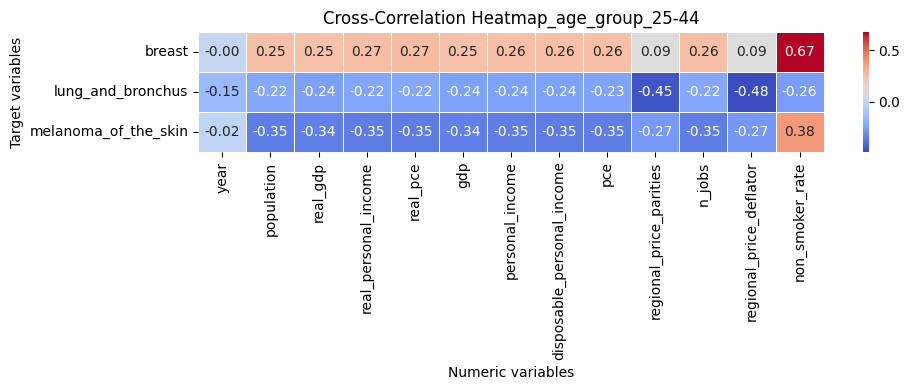

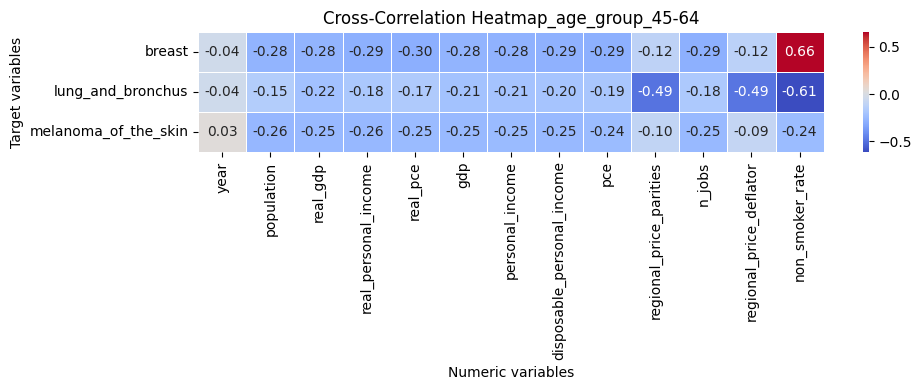

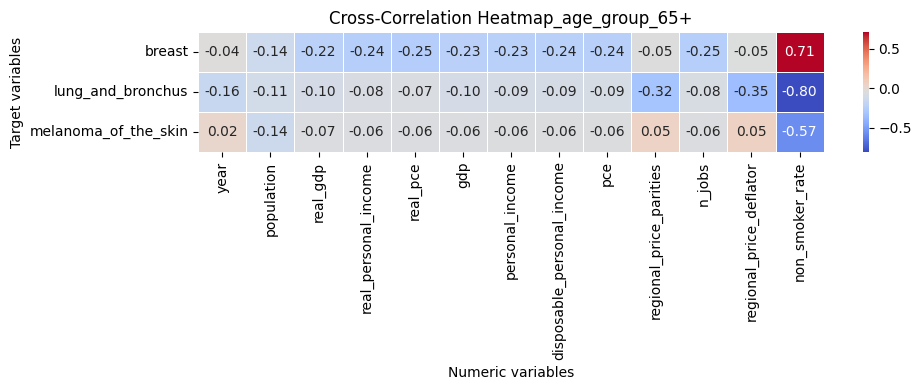

In [22]:
plot_cross_correlation_heatmap(
    cancer_rate_pop_econ_nons_df,
    target_vars=["breast", "lung_and_bronchus", "melanoma_of_the_skin"],
    group_col="age_group",
    groups=None,
    corr_threshold=None,
    title_prefix="Cross-Correlation Heatmap",
    figsize=(10, 4),
    cmap="coolwarm",
    save_path="figures",
)

#### Summary (Numeric economic indicators and non-smoker rate): 
1. Population number is negatively correlated with cancer rate, for all cancer types.
2. Regional (state-wise) non-smoker rate is positively correlated with breast cancer rate, but negatively correlated with "Melanoma of the Skin" and "Lung and Bronchus".    
2. Most economic indicators are negatively correlated with three cancer types, except regional_price_deflator and regional_price_partities on "Melanoma of the Skin" cancers which are positive.

### Section 4: Predictive modeling of cancer rates using the provided features

#### What included here are 
* RandomizedSearchCV
    - 1️⃣ step by step XGBoost model
    - 2️⃣ Refactored Python Code (Configurations in a YAML file)
    - 3️⃣ Refactored Python Code (Pedantic Validation)
* Hyperparameter optimization via Optuna
    - 4️⃣ 
    - 5️⃣
    - 6️⃣
    - 7️⃣
    - 8️⃣
    - 9️⃣
    - 🔟

In [ ]:
# df = pd.read_csv(...)

df = cancer_rate_pop_econ_nons_df
target_columns = ["breast", "lung_and_bronchus", "melanoma_of_the_skin"]

# Inpute the responses
from sklearn.impute import SimpleImputer

# Imput missing in pd.DataFrame
df[target_columns] = SimpleImputer(strategy="mean").fit_transform(df[target_columns])


# Optional - Save
df.to_parquet(DATA_DIR / "model_df.parquet")

df.to_csv(DATA_DIR / "model_df.csv")

In [37]:
df.drop(columns=["states", "fips", "sex"]).dtypes

year                            int64
sex_code                       object
age_group                      object
population                      Int64
breast                        float64
lung_and_bronchus             float64
melanoma_of_the_skin          float64
real_gdp                      float64
real_personal_income          float64
real_pce                      float64
gdp                           float64
personal_income               float64
disposable_personal_income    float64
pce                           float64
regional_price_parities       float64
n_jobs                        float64
regional_price_deflator       float64
states_abbr                    object
non_smoker_rate               float64
dtype: object

In [24]:
# Step by step XGBoost model

import pandas as pd
import numpy as np

from pathlib import Path
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin

from xgboost import XGBRegressor
from scipy.stats import randint, uniform, loguniform


# -----------------------------
# 1️⃣ Step 1: Load dataset
# -----------------------------
# df = pd.read_csv('your_dataset.csv')  # Replace with your dataset
df = pd.read_parquet(DATA_DIR / "model_df.parquet")

X = df.drop(columns=target_columns)
y = df[target_columns]

# -----------------------------
# 2️⃣ Step 2: Column types
# -----------------------------
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "category"]).columns

# -----------------------------
# 3️⃣ Step 3: Preprocessing
# -----------------------------
numeric_transformer = Pipeline([("scaler", StandardScaler())])

categorical_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


# -----------------------------
# 4️⃣ Step 4: XGBoost
# -----------------------------
class XGB(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        # 🔒 Penalization
        reg_alpha=0.0,
        reg_lambda=1.0,
        gamma=0.0,
        min_child_weight=1.0,
        max_delta_step=0.0,
        random_state=42,
        tree_method="auto",
    ):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.reg_alpha = reg_alpha
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.min_child_weight = min_child_weight
        self.max_delta_step = max_delta_step
        self.random_state = random_state
        self.tree_method = tree_method

    def fit(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state
        )

        self.model_ = XGBRegressor(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            subsample=self.subsample,
            colsample_bytree=self.colsample_bytree,
            # 🔒 Penalization wired through
            reg_alpha=self.reg_alpha,
            reg_lambda=self.reg_lambda,
            gamma=self.gamma,
            min_child_weight=self.min_child_weight,
            max_delta_step=self.max_delta_step,
            objective="reg:squarederror",
            random_state=self.random_state,
            tree_method=self.tree_method,
        )

        self.model_.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            verbose=False,
        )
        return self

    def predict(self, X):
        return self.model_.predict(X)


# -----------------------------
# 5️⃣ Step 5: Full pipeline
# -----------------------------
pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "regressor",
            MultiOutputRegressor(XGB(tree_method="auto")),
        ),
    ]
)

# -----------------------------
# 6️⃣ Step 6: Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 7️⃣ Step 7: RandomizedSearchCV
# -----------------------------
param_distributions = {
    "regressor__estimator__n_estimators": randint(500, 1500),
    "regressor__estimator__max_depth": randint(3, 10),
    "regressor__estimator__learning_rate": uniform(0.01, 0.2),
    "regressor__estimator__subsample": uniform(0.7, 0.3),
    "regressor__estimator__colsample_bytree": uniform(0.7, 0.3),
    # 🔒 Penalization / regularization
    "regressor__estimator__reg_alpha": loguniform(1e-3, 10.0),
    "regressor__estimator__reg_lambda": loguniform(1.0, 20.0),
    "regressor__estimator__gamma": uniform(0.0, 10.0),
    "regressor__estimator__min_child_weight": uniform(1.0, 20.0),
    "regressor__estimator__max_delta_step": uniform(0.0, 10.0),
}
# Note: In scikit-learn, hyperparameter names must follow the exact path (using __) to the estimator. regressor: MultiOutputRegressor estimator: XGBRegressor

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="r2",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42,
)

# -----------------------------
# 8️⃣ Step 8: Train
# -----------------------------
search.fit(X_train, y_train)

# -----------------------------
# 9️⃣ Step 9: Evaluation (per target)
# -----------------------------
y_pred = search.predict(X_test)

for i, target in enumerate(target_columns):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{target} → MSE: {mse:.4f}, R²: {r2:.4f}")

print("\nBest params:", search.best_params_)  # With pipeline prefixes

# -----------------------------
# 🔟 Step 10: Update Model Pipeline with Best Parameters
# -----------------------------
# Get the best parameters
best_params = search.best_params_
print(best_params)

# Strip pipeline prefixes
xgb_best_params = {
    k.replace("regressor__estimator__", ""): v for k, v in best_params.items()
}

print("\nBest model params:", xgb_best_params)


# Build the FINAL inference model
final_xgb = XGBRegressor(
    **xgb_best_params,
    objective="reg:squarederror",
    random_state=42,
    tree_method="auto",  # or "hist", "exact"
)

# Final multi-target pipeline (Inference-ready)
final_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),  # SAME preprocessing
        ("regressor", MultiOutputRegressor(final_xgb)),
    ]
)


# Refit on ALL training data
final_pipeline.fit(X_train, y_train)


# import joblib

# final_pipeline.save("multioutput_xgb_pipeline.pkl")
# final_pipeline.load("multioutput_xgb_pipeline.pkl")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END regressor__estimator__colsample_bytree=0.8542703315240834, regressor__estimator__gamma=5.924145688620425, regressor__estimator__learning_rate=0.019290082543999547, regressor__estimator__max_delta_step=6.075448519014383, regressor__estimator__max_depth=7, regressor__estimator__min_child_weight=10.009985039390859, regressor__estimator__n_estimators=773, regressor__estimator__reg_alpha=6.245139574743075, regressor__estimator__reg_lambda=18.043311207136256, regressor__estimator__subsample=0.9425192044349383; total time=   3.3s
[CV] END regressor__estimator__colsample_bytree=0.8542703315240834, regressor__estimator__gamma=5.924145688620425, regressor__estimator__learning_rate=0.019290082543999547, regressor__estimator__max_delta_step=6.075448519014383, regressor__estimator__max_depth=7, regressor__estimator__min_child_weight=10.009985039390859, regressor__estimator__n_estimators=773, regressor__estimator__reg_alpha=6.2451

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformer

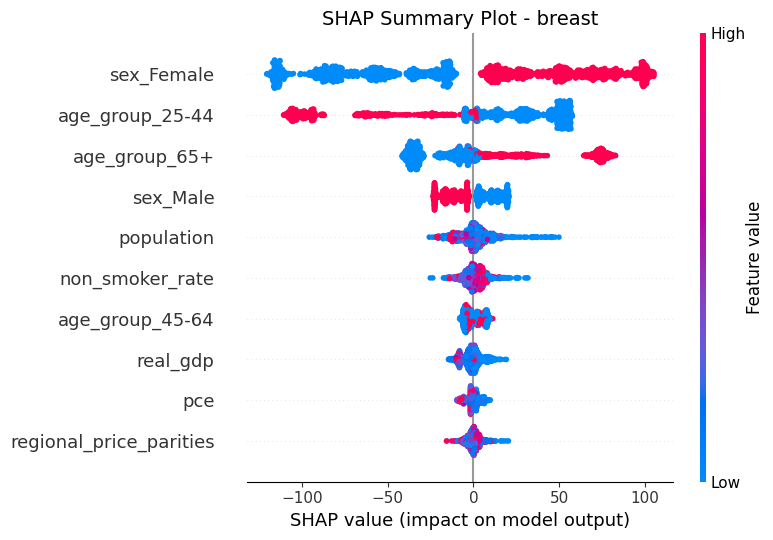

Saved SHAP plot for breast → figures/shap_summary_breast.png


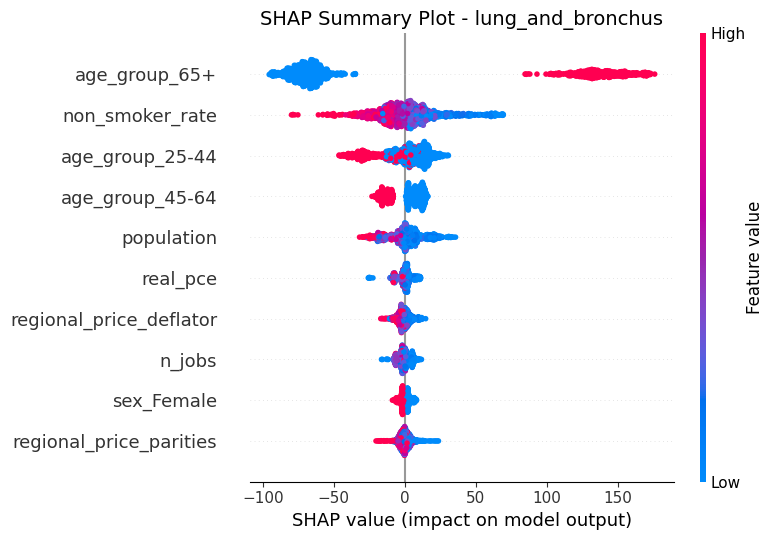

Saved SHAP plot for lung_and_bronchus → figures/shap_summary_lung_and_bronchus.png


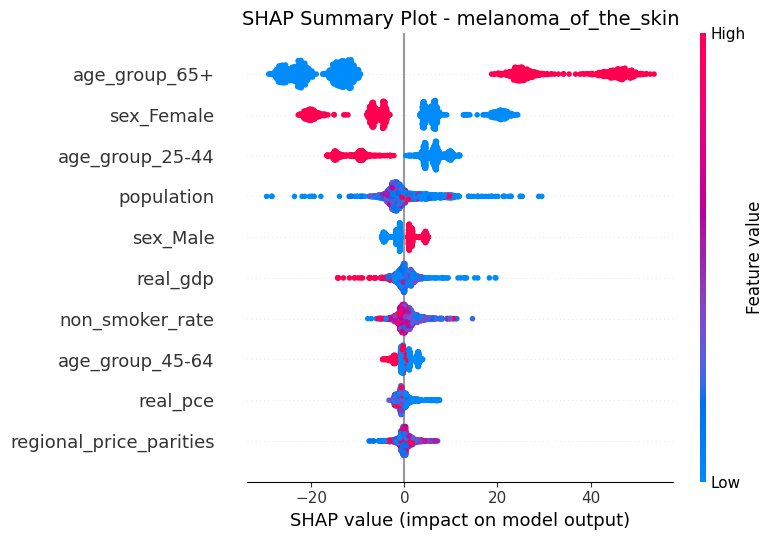

Saved SHAP plot for melanoma_of_the_skin → figures/shap_summary_melanoma_of_the_skin.png


In [25]:
# SHAP summary plot
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plot_shap_summary(
    pipeline: Pipeline,
    X: pd.DataFrame,
    target_columns: list[str],
    max_display: int = 20,
    save_path: Path | None = None,
    sample_size: int | None = None,
    random_state: int = 42,
) -> None:
    """
    SHAP summary plots for MultiOutputRegressor with ColumnTransformer.

    Args:
        pipeline: Trained pipeline with preprocessor + MultiOutputRegressor
        X: Original feature DataFrame (before preprocessing)
        target_columns: List of target column names
        max_display: Maximum number of features to display (default 20)
        save_path: Folder path to save plots. If None, plots are only displayed
        sample_size: Optional int to randomly sample rows from X for faster plotting
        random_state: Random seed for sampling (default 42)
    """
    # Optional sampling for large datasets
    if sample_size is not None and sample_size < len(X):
        X = X.sample(sample_size, random_state=random_state)

    # Preprocess features
    preprocessor = pipeline.named_steps["preprocessor"]
    X_transformed = preprocessor.transform(X)

    # Get feature names from numeric + one-hot encoded categorical
    numeric_features = preprocessor.transformers_[0][2]
    cat_features = preprocessor.transformers_[1][2]
    cat_onehot = preprocessor.transformers_[1][1].named_steps["onehot"]
    cat_onehot_names = cat_onehot.get_feature_names_out(cat_features)
    feature_names = list(numeric_features) + list(cat_onehot_names)

    # Build color array
    # Numeric features: original values
    numeric_values = X[numeric_features].to_numpy()

    # Categorical features: map to one-hot columns
    cat_onehot_values = cat_onehot.transform(X[cat_features]).toarray()

    # Combine numeric + categorical
    color_array = np.hstack([numeric_values, cat_onehot_values])

    # Loop over each target
    for i, target in enumerate(target_columns):
        model_i = pipeline.named_steps["regressor"].estimators_[i]

        # SHAP Explainer
        explainer = shap.Explainer(model_i)
        shap_values = explainer(X_transformed)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.title(f"SHAP Summary Plot - {target}", fontsize=14)
        shap.summary_plot(
            shap_values,
            color_array,  # Must match shape of SHAP values
            feature_names=feature_names,
            max_display=max_display,
            show=True,
        )

        # Save if requested
        if save_path is not None:
            filename = save_path / f"shap_summary_{target}.png"
            plt.savefig(filename, bbox_inches="tight", dpi=150)
            plt.close()  # Free memory
            print(f"Saved SHAP plot for {target} → {filename}")


# Run inference
y_pred = final_pipeline.predict(X)

# Save the model
import joblib

joblib.dump(final_pipeline, "xgb_multioutput_pipeline.pkl")

# Load and inference new data
import joblib

final_pipeline = joblib.load("xgb_multioutput_pipeline.pkl")

y_pred = final_pipeline.predict(X)

# # Plot and save the SHAP summary
plot_shap_summary(
    final_pipeline, X, target_columns, max_display=10, save_path=Path("figures")
)

In [26]:
# Refactored Python Code (Configurations in a YAML file)

from __future__ import annotations

import logging
import yaml
from pathlib import Path
from typing import Any

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from scipy.stats import randint, uniform, loguniform


# ------------------------------------------------------------------------------
# Logging
# ------------------------------------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
)
LOGGER = logging.getLogger(__name__)


# ------------------------------------------------------------------------------
# Config
# ------------------------------------------------------------------------------
def load_config(path: Path) -> dict[str, Any]:
    with path.open() as f:
        return yaml.safe_load(f)


# ------------------------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------------------------
def build_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
    categorical_features = X.select_dtypes(include=["object", "category"]).columns

    return ColumnTransformer(
        transformers=[
            ("num", Pipeline([("scaler", StandardScaler())]), numeric_features),
            (
                "cat",
                Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]),
                categorical_features,
            ),
        ]
    )


# ------------------------------------------------------------------------------
# Model
# ------------------------------------------------------------------------------
def build_pipeline(
    preprocessor: ColumnTransformer, xgb_params: dict[str, Any]
) -> Pipeline:
    model = XGBRegressor(**xgb_params)
    return Pipeline(
        [
            ("preprocessor", preprocessor),
            ("regressor", MultiOutputRegressor(model)),
        ]
    )


# ------------------------------------------------------------------------------
# Hyperparameter Space
# ------------------------------------------------------------------------------
def build_search_space(cfg: dict[str, Any]) -> dict[str, Any]:
    s = cfg["xgboost"]["search_space"]
    return {
        "regressor__estimator__n_estimators": randint(*s["n_estimators"]),
        "regressor__estimator__max_depth": randint(*s["max_depth"]),
        "regressor__estimator__learning_rate": uniform(*s["learning_rate"]),
        "regressor__estimator__subsample": uniform(
            s["subsample"][0], s["subsample"][1] - s["subsample"][0]
        ),
        "regressor__estimator__colsample_bytree": uniform(
            s["colsample_bytree"][0],
            s["colsample_bytree"][1] - s["colsample_bytree"][0],
        ),
        "regressor__estimator__reg_alpha": loguniform(*s["reg_alpha"]),
        "regressor__estimator__reg_lambda": loguniform(*s["reg_lambda"]),
        "regressor__estimator__gamma": uniform(*s["gamma"]),
        "regressor__estimator__min_child_weight": uniform(*s["min_child_weight"]),
        "regressor__estimator__max_delta_step": uniform(*s["max_delta_step"]),
    }


# ------------------------------------------------------------------------------
# Training
# ------------------------------------------------------------------------------
def train(df: pd.DataFrame, cfg: dict[str, Any]) -> Pipeline:
    targets = cfg["data"]["target_columns"]

    X = df.drop(columns=targets)
    y = df[targets]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=cfg["project"]["test_size"],
        random_state=cfg["project"]["random_state"],
    )

    preprocessor = build_preprocessor(X)

    base_xgb_params = cfg["xgboost"]["fixed_params"]
    pipeline = build_pipeline(preprocessor, base_xgb_params)

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=build_search_space(cfg),
        n_iter=cfg["training"]["randomized_search"]["n_iter"],
        scoring=cfg["training"]["randomized_search"]["scoring"],
        cv=cfg["project"]["cv_folds"],
        verbose=cfg["training"]["randomized_search"]["verbose"],
        n_jobs=cfg["project"]["n_jobs"],
        random_state=cfg["project"]["random_state"],
    )

    LOGGER.info("Starting hyperparameter search")
    search.fit(X_train, y_train)

    LOGGER.info("Evaluating model")
    y_pred = search.predict(X_test)

    for i, target in enumerate(targets):
        LOGGER.info(
            "%s | MSE: %.4f | R2: %.4f",
            target,
            mean_squared_error(y_test.iloc[:, i], y_pred[:, i]),
            r2_score(y_test.iloc[:, i], y_pred[:, i]),
        )

    LOGGER.info("Best parameters: %s", search.best_params_)

    # ------------------------------------------------------------------
    # Final Inference Model (refit on all data)
    # ------------------------------------------------------------------
    best_params = {
        k.replace("regressor__estimator__", ""): v
        for k, v in search.best_params_.items()
    }

    final_xgb = XGBRegressor(**base_xgb_params, **best_params)
    final_pipeline = build_pipeline(preprocessor, final_xgb.get_params())

    final_pipeline.fit(X, y)
    return final_pipeline


CONFIG_PATH = Path("conf/config.yaml")

# ------------------------------------------------------------------------------
# Entry Point
# ------------------------------------------------------------------------------
# if __name__ == "__main__":
#     CONFIG_PATH = Path("conf/config.yaml")

config = load_config(CONFIG_PATH)

df = pd.read_parquet(DATA_DIR / "model_df.parquet")

model = train(df, config)

# import joblib

# model.save("multioutput_xgb_pipeline.pkl")
# model.load("multioutput_xgb_pipeline.pkl")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END regressor__estimator__colsample_bytree=0.8793699936433255, regressor__estimator__gamma=9.218742350231167, regressor__estimator__learning_rate=0.0276985004103839, regressor__estimator__max_delta_step=1.959828624191452, regressor__estimator__max_depth=3, regressor__estimator__min_child_weight=20.22344048698698, regressor__estimator__n_estimators=1224, regressor__estimator__reg_alpha=0.03586816498627549, regressor__estimator__reg_lambda=2.2544116997360484, regressor__estimator__subsample=0.9486212527455788; total time=   2.1s
[CV] END regressor__estimator__colsample_bytree=0.8793699936433255, regressor__estimator__gamma=9.218742350231167, regressor__estimator__learning_rate=0.0276985004103839, regressor__estimator__max_delta_step=1.959828624191452, regressor__estimator__max_depth=3, regressor__estimator__min_child_weight=20.22344048698698, regressor__estimator__n_estimators=1224, regressor__estimator__reg_alpha=0.035868

In [27]:
# Refactored Python Code (Pedantic Validation)

from __future__ import annotations

import logging
from pathlib import Path
from typing import Any, Literal

import yaml
import numpy as np
import pandas as pd

from pydantic import BaseModel, Field, ConfigDict, field_validator, model_validator

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from scipy.stats import randint, uniform, loguniform


# ------------------------------------------------------------------------------
# Logging
# ------------------------------------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
)
LOGGER = logging.getLogger(__name__)


# ------------------------------------------------------------------------------
# Config Models (PEDANTIC)
# ------------------------------------------------------------------------------
class ProjectConfig(BaseModel):
    random_state: int
    test_size: float = Field(gt=0.0, lt=1.0)
    cv_folds: int = Field(gt=1)
    n_jobs: int


class DataConfig(BaseModel):
    target_columns: list[str] = Field(min_length=1)
    numeric_scaling: Literal["standard"]
    categorical_encoding: Literal["onehot"]


class SearchSpaceConfig(BaseModel):
    n_estimators: tuple[int, int]
    max_depth: tuple[int, int]
    learning_rate: tuple[float, float]
    subsample: tuple[float, float]
    colsample_bytree: tuple[float, float]
    reg_alpha: tuple[float, float]
    reg_lambda: tuple[float, float]
    gamma: tuple[float, float]
    min_child_weight: tuple[float, float]
    max_delta_step: tuple[float, float]

    @field_validator("*")
    @classmethod
    def validate_bounds(cls, v: tuple[float, float]):
        lo, hi = v
        if lo >= hi:
            raise ValueError(f"Invalid range {v}: lower must be < upper")
        return v


class XGBoostConfig(BaseModel):
    fixed_params: dict[str, Any]
    search_space: SearchSpaceConfig


class RandomizedSearchConfig(BaseModel):
    n_iter: int = Field(gt=0)
    scoring: str
    verbose: int = Field(ge=0)


class TrainingConfig(BaseModel):
    randomized_search: RandomizedSearchConfig


class ModelConfig(BaseModel):
    model_config = ConfigDict(extra="forbid")

    project: ProjectConfig
    data: DataConfig
    xgboost: XGBoostConfig
    training: TrainingConfig


# ------------------------------------------------------------------------------
# Config Loader
# ------------------------------------------------------------------------------
def load_config(path: Path) -> ModelConfig:
    if not path.exists():
        raise FileNotFoundError(f"Config file not found: {path}")

    with path.open() as f:
        raw = yaml.safe_load(f)
        # At this point, raw is a plan dict[str, Any]. No typing/validation/guarantees

    try:
        # Pydantic Model classes method model_validate(): Validates the given object against the Pydantic model.
        return ModelConfig.model_validate(raw)
        # Pydantic now treats raw as input that must conform to ModelConfig, and Recursive Expansion happends automatically.
    except Exception as e:
        raise ValueError(f"Invalid configuration:\n{e}") from e


# ------------------------------------------------------------------------------
# Data Validation
# ------------------------------------------------------------------------------
def validate_dataframe(df: pd.DataFrame, targets: list[str]) -> None:
    if df.empty:
        raise ValueError("Input DataFrame is empty")

    missing = set(targets) - set(df.columns)
    if missing:
        raise ValueError(f"Missing target columns: {missing}")

    if df[targets].shape[1] != len(targets):
        raise ValueError("Duplicate target columns detected")

    feature_cols = set(df.columns) - set(targets)
    if not feature_cols:
        raise ValueError("No feature columns available after removing targets")


# ------------------------------------------------------------------------------
# Preprocessing
# ------------------------------------------------------------------------------
def build_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_features = X.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()

    if not numeric_features and not categorical_features:
        raise ValueError("No usable numeric or categorical features found")

    transformers = []

    if numeric_features:
        transformers.append(
            ("num", Pipeline([("scaler", StandardScaler())]), numeric_features)
        )

    if categorical_features:
        transformers.append(
            (
                "cat",
                Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]),
                categorical_features,
            )
        )

    return ColumnTransformer(transformers)


# ------------------------------------------------------------------------------
# Model
# ------------------------------------------------------------------------------
def build_pipeline(
    preprocessor: ColumnTransformer, xgb_params: dict[str, Any]
) -> Pipeline:
    model = XGBRegressor(**xgb_params)
    return Pipeline(
        [
            ("preprocessor", preprocessor),
            ("regressor", MultiOutputRegressor(model)),
        ]
    )


# ------------------------------------------------------------------------------
# Hyperparameter Space
# ------------------------------------------------------------------------------
def build_search_space(cfg: SearchSpaceConfig) -> dict[str, Any]:
    return {
        "regressor__estimator__n_estimators": randint(*cfg.n_estimators),
        "regressor__estimator__max_depth": randint(*cfg.max_depth),
        "regressor__estimator__learning_rate": uniform(*cfg.learning_rate),
        "regressor__estimator__subsample": uniform(
            cfg.subsample[0], cfg.subsample[1] - cfg.subsample[0]
        ),
        "regressor__estimator__colsample_bytree": uniform(
            cfg.colsample_bytree[0],
            cfg.colsample_bytree[1] - cfg.colsample_bytree[0],
        ),
        "regressor__estimator__reg_alpha": loguniform(*cfg.reg_alpha),
        "regressor__estimator__reg_lambda": loguniform(*cfg.reg_lambda),
        "regressor__estimator__gamma": uniform(*cfg.gamma),
        "regressor__estimator__min_child_weight": uniform(*cfg.min_child_weight),
        "regressor__estimator__max_delta_step": uniform(*cfg.max_delta_step),
    }


# ------------------------------------------------------------------------------
# Training
# ------------------------------------------------------------------------------
def train(df: pd.DataFrame, cfg: ModelConfig) -> Pipeline:
    validate_dataframe(df, cfg.data.target_columns)

    X = df.drop(columns=cfg.data.target_columns)
    y = df[cfg.data.target_columns]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=cfg.project.test_size,
        random_state=cfg.project.random_state,
    )

    preprocessor = build_preprocessor(X)

    pipeline = build_pipeline(preprocessor, cfg.xgboost.fixed_params)

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=build_search_space(cfg.xgboost.search_space),
        n_iter=cfg.training.randomized_search.n_iter,
        scoring=cfg.training.randomized_search.scoring,
        cv=cfg.project.cv_folds,
        verbose=cfg.training.randomized_search.verbose,
        n_jobs=cfg.project.n_jobs,
        random_state=cfg.project.random_state,
    )

    LOGGER.info("Starting hyperparameter search")
    search.fit(X_train, y_train)

    LOGGER.info("Evaluating model")
    y_pred = search.predict(X_test)

    for i, target in enumerate(cfg.data.target_columns):
        LOGGER.info(
            "%s | MSE: %.4f | R2: %.4f",
            target,
            mean_squared_error(y_test.iloc[:, i], y_pred[:, i]),
            r2_score(y_test.iloc[:, i], y_pred[:, i]),
        )

    LOGGER.info("Best parameters: %s", search.best_params_)

    best_params = {
        k.replace("regressor__estimator__", ""): v
        for k, v in search.best_params_.items()
    }

    final_xgb = XGBRegressor(**cfg.xgboost.fixed_params, **best_params)
    final_pipeline = build_pipeline(preprocessor, final_xgb.get_params())

    final_pipeline.fit(X, y)
    return final_pipeline

In [28]:
config = load_config(CONFIG_PATH)

df = pd.read_parquet(DATA_DIR / "model_df.parquet")

model = train(df, config)

# import joblib

# model.save("multioutput_xgb_pipeline.pkl")
# model.load("multioutput_xgb_pipeline.pkl")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END regressor__estimator__colsample_bytree=0.8793699936433255, regressor__estimator__gamma=9.218742350231167, regressor__estimator__learning_rate=0.0276985004103839, regressor__estimator__max_delta_step=1.959828624191452, regressor__estimator__max_depth=3, regressor__estimator__min_child_weight=20.22344048698698, regressor__estimator__n_estimators=1224, regressor__estimator__reg_alpha=0.03586816498627549, regressor__estimator__reg_lambda=2.2544116997360484, regressor__estimator__subsample=0.9486212527455788; total time=   2.3s
[CV] END regressor__estimator__colsample_bytree=0.8793699936433255, regressor__estimator__gamma=9.218742350231167, regressor__estimator__learning_rate=0.0276985004103839, regressor__estimator__max_delta_step=1.959828624191452, regressor__estimator__max_depth=3, regressor__estimator__min_child_weight=20.22344048698698, regressor__estimator__n_estimators=1224, regressor__estimator__reg_alpha=0.035868

[I 2026-01-08 18:05:44,695] A new study created in memory with name: no-name-98b20e3d-c633-479c-a7bd-2eb502ce1485
[I 2026-01-08 18:05:46,621] Trial 0 finished with value: 32.30871792530271 and parameters: {'n_estimators': 961, 'max_depth': 6, 'learning_rate': 0.02999510886958158, 'subsample': 0.952974904375822, 'colsample_bytree': 0.8571817608871692, 'reg_alpha': 7.928528508012404, 'reg_lambda': 1.150173124355285, 'gamma': 8.690311507329756, 'min_child_weight': 14.619006677222929, 'max_delta_step': 8.535831853045153}. Best is trial 0 with value: 32.30871792530271.
[I 2026-01-08 18:05:47,594] Trial 1 finished with value: 31.41951714494033 and parameters: {'n_estimators': 965, 'max_depth': 3, 'learning_rate': 0.043498888953521914, 'subsample': 0.8334713239282802, 'colsample_bytree': 0.8508487193303582, 'reg_alpha': 1.2817322424664277, 'reg_lambda': 13.114929785015754, 'gamma': 0.5190501245605961, 'min_child_weight': 17.347784987396853, 'max_delta_step': 7.909744883235945}. Best is trial 

Best RMSE (validation): 29.848575545936033
Best hyperparameters: {'n_estimators': 1040, 'max_depth': 5, 'learning_rate': 0.06250732567958708, 'subsample': 0.8542292888777906, 'colsample_bytree': 0.7367552339830437, 'reg_alpha': 1.0796285176765026, 'reg_lambda': 5.678352791535289, 'gamma': 7.055857128914719, 'min_child_weight': 4.955756024792933, 'max_delta_step': 8.02713808059752}


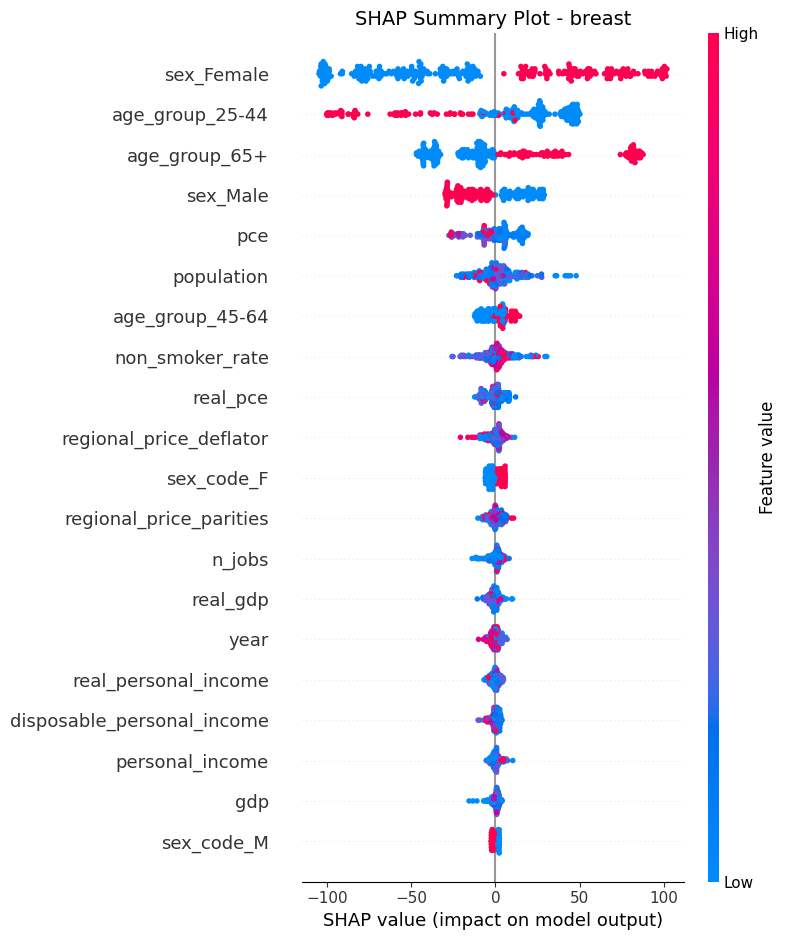

Saved SHAP plot for breast → figures/shap_summary_breast.png


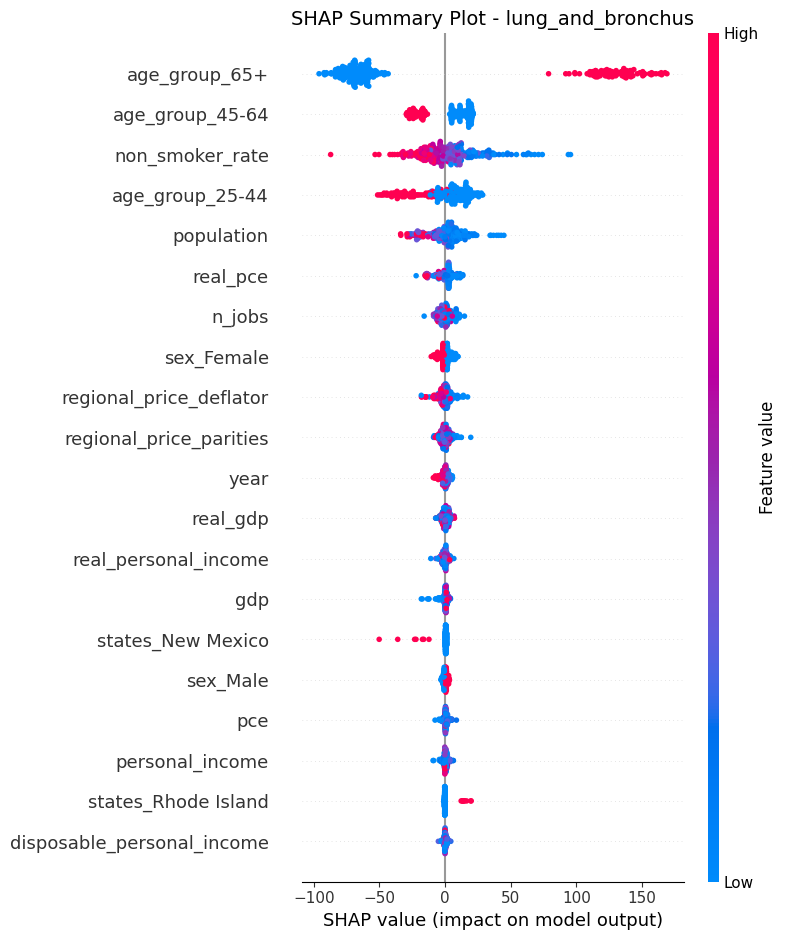

Saved SHAP plot for lung_and_bronchus → figures/shap_summary_lung_and_bronchus.png


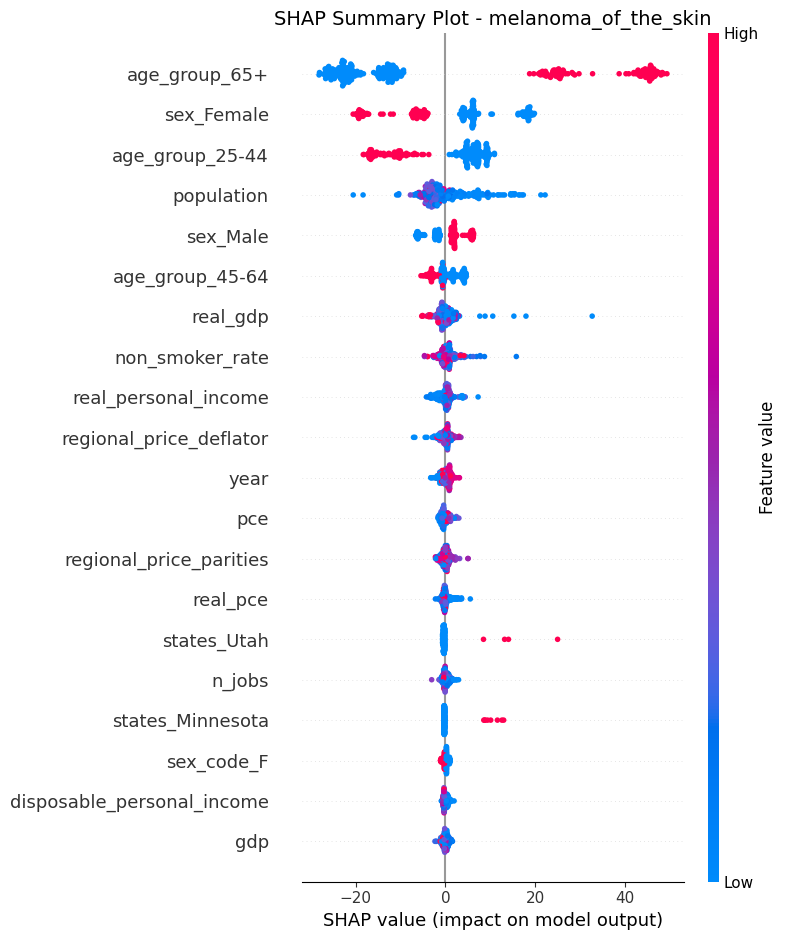

Saved SHAP plot for melanoma_of_the_skin → figures/shap_summary_melanoma_of_the_skin.png


In [29]:
#  Hyperparameter optimization via Optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import optuna
import shap
import joblib


class MultiTargetXGB:
    def __init__(self, target_names, tree_method="auto", random_state=42):
        """
        Multi-target XGBoost pipeline with:
        - Optuna Bayesian hyperparameter tuning
        - NumPy-safe RMSE
        - SHAP explainability per target
        """
        self.target_names = target_names
        self.tree_method = tree_method
        self.random_state = random_state
        self.pipeline = None
        self.best_params = None
        self.preprocessor = None

    # -----------------------------
    # Step 1: Build preprocessing
    # -----------------------------
    def _build_preprocessor(self, X):
        numeric_features = X.select_dtypes(
            include=["int64", "float64"]
        ).columns.tolist()
        categorical_features = X.select_dtypes(
            include=["object", "category"]
        ).columns.tolist()

        numeric_transformer = Pipeline([("scaler", StandardScaler())])
        categorical_transformer = Pipeline(
            [("onehot", OneHotEncoder(handle_unknown="ignore"))]
        )

        self.preprocessor = ColumnTransformer(
            [
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer, categorical_features),
            ]
        )
        return self.preprocessor

    # -----------------------------
    # Step 2: Optuna objective (NumPy-safe)
    # -----------------------------
    def _objective(self, trial, X_train, X_val, y_train, y_val):
        params = {
            # Core model complexity
            "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
            # 🔒 Penalization / regularization
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 20.0, log=True),
            "gamma": trial.suggest_float("gamma", 0.0, 10.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 20.0),
            "max_delta_step": trial.suggest_float("max_delta_step", 0.0, 10.0),
            # Fixed
            "tree_method": self.tree_method,
            "random_state": self.random_state,
            "objective": "reg:squarederror",
        }

        model = MultiOutputRegressor(XGBRegressor(**params))
        model.fit(self.preprocessor.fit_transform(X_train), np.array(y_train))
        y_pred = model.predict(self.preprocessor.transform(X_val))

        # NumPy-safe RMSE
        y_val_np = np.array(y_val)
        rmse = np.mean(
            [
                np.sqrt(mean_squared_error(y_val_np[:, i], y_pred[:, i]))
                for i in range(y_val_np.shape[1])
            ]
        )
        return rmse

    # -----------------------------
    # Step 3: Fit with Optuna
    # -----------------------------
    def fit(self, X, y, n_trials=30, test_size=0.2):
        """
        Fit the multi-target pipeline with Optuna Bayesian hyperparameter tuning.
        """
        self._build_preprocessor(X)
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state
        )

        # Run Optuna study
        study = optuna.create_study(direction="minimize")
        func = lambda trial: self._objective(trial, X_train, X_val, y_train, y_val)
        study.optimize(func, n_trials=n_trials)

        print("Best RMSE (validation):", study.best_value)
        self.best_params = study.best_params
        print("Best hyperparameters:", self.best_params)

        # Refit final model on all data
        final_model = MultiOutputRegressor(
            XGBRegressor(
                **self.best_params,
                tree_method=self.tree_method,
                random_state=self.random_state,
                objective="reg:squarederror",
            )
        )

        self.pipeline = Pipeline(
            [("preprocessor", self.preprocessor), ("regressor", final_model)]
        )

        self.pipeline.fit(X, np.array(y))
        return self

    # -----------------------------
    # Step 4: Predict
    # -----------------------------
    def predict(self, X_new):
        return self.pipeline.predict(X_new)

    # -----------------------------
    # Step 5: SHAP explainability
    # -----------------------------
    def shap_summary_colored(
        self,
        X_orig: pd.DataFrame,
        target_names: list[str],
        max_display: int = 20,
        save_path: Path | None = None,
    ):
        """
        SHAP summary plot for multi-target XGBoost pipeline.

        Parameters
        ----------
        X_orig : pd.DataFrame
            Original features (for coloring)
        target_names : list[str]
            Names of targets corresponding to the MultiOutputRegressor
        max_display: int
            Maximum number of features to display (default 20)
        save_path: Path | None
            Folder path to save plots. If None, plots are only displayed

        """
        preprocessor = self.pipeline.named_steps["preprocessor"]
        X_transformed = preprocessor.transform(X_orig)

        # Feature names
        numeric_features = preprocessor.transformers_[0][2]
        cat_features = preprocessor.transformers_[1][2]
        cat_onehot = preprocessor.transformers_[1][1].named_steps["onehot"]
        cat_onehot_names = cat_onehot.get_feature_names_out(cat_features)
        feature_names = list(numeric_features) + list(cat_onehot_names)

        # Build color array
        # Numeric features: original values
        numeric_values = X_orig[numeric_features].to_numpy()

        # Categorical features: map to one-hot columns
        cat_onehot_values = cat_onehot.transform(X_orig[cat_features]).toarray()

        # Combine numeric + categorical
        color_array = np.hstack([numeric_values, cat_onehot_values])

        # Loop over each target
        for i, target in enumerate(target_names):
            model_i = self.pipeline.named_steps["regressor"].estimators_[i]
            explainer = shap.Explainer(model_i)
            shap_values = explainer(X_transformed)

            plt.figure(figsize=(12, 6))
            plt.title(f"SHAP Summary Plot - {target}", fontsize=14)
            shap.summary_plot(
                shap_values,
                color_array,  # Must match shape of SHAP values
                feature_names=feature_names,
                max_display=max_display,
                show=True,
            )
            # Save if requested
            if save_path is not None:
                filename = save_path / f"shap_summary_{target}.png"
                plt.savefig(filename, bbox_inches="tight", dpi=150)
                plt.close()  # Free memory
                print(f"Saved SHAP plot for {target} → {filename}")

    # -----------------------------
    # Step 6: Save / Load
    # -----------------------------
    def save(self, filepath="multioutput_xgb.pkl"):
        joblib.dump(self.pipeline, filepath)

    def load(self, filepath="multioutput_xgb.pkl"):
        self.pipeline = joblib.load(filepath)
        return self


# ✅ Usage Example

df = pd.read_parquet(DATA_DIR / "model_df.parquet")

# Targets
target_names = ["breast", "lung_and_bronchus", "melanoma_of_the_skin"]

# Initialize class
mt_xgb = MultiTargetXGB(target_names=target_names, tree_method="auto")

# Fit with Bayesian Optuna tuning
X = df.drop(columns=target_names)
y = df[target_names]

mt_xgb.fit(X, y, n_trials=50)

# SHAP explainability per target
mt_xgb.shap_summary_colored(X_test, target_names, save_path=Path("figures"))

# Save & load
import joblib

mt_xgb.save("multioutput_xgb_pipeline.pkl")
mt_xgb.load("multioutput_xgb_pipeline.pkl")